In [67]:
def Static_Model(edges, weights, nodes, source, destination):

    from pyqubo import Array,Constraint,Placeholder
    
    x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') 

    i = 0
    fcost = 0
    for i in range(len(edges)):
        fcost += (weights[i]*x[i]) ## Put the expression for constraints in

    p = 27
    node=1
    while(node<=nodes):
        sum = 0
        for j in range(len(edges)):
            if edges[j][0] == node: ##Outgoing from the current node
                sum += x[j]
            elif edges[j][1] == node: ##Incoming into the current node
                sum -= x[j]

        if node == source:
            sum -= 1
        elif node== destination:
            sum += 1

        fcost += p*((sum)**2)
        node+=1

    model = fcost.compile()

    linear, quadratic, offset = model.to_ising()

    # general imports
    import numpy as np
    import matplotlib.pyplot as plt
    # magic word for producing visualizations in notebook
    get_ipython().run_line_magic('matplotlib', 'inline')
    import string
    import time

    # AWS imports: Import Braket SDK modules
    from braket.circuits import Circuit, Gate, Observable
    from braket.devices import LocalSimulator
    from braket.aws import AwsDevice, AwsQuantumTask


    # In[28]:


    def create_circuit(beta, gamma):
        ## initializing the initial qubit state with H gates ##
        circuit = Circuit()
        n_qubits = len(edges)

        for qubit in range(n_qubits):
            circuit.h(qubit)

        ## Implementing the problem Hamiltonian ##
        for qubit in range(n_qubits):
            linear_coeff = linear.get('x['+str(qubit)+']')
            circuit = circuit.rz(qubit, -1*linear_coeff)

        #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
        for i in range(len(quadratic)):
            qubit_1 = int(list(quadratic.keys())[i][0][2])
            qubit_2 = int(list(quadratic.keys())[i][1][2])

            quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))

            circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)

        ## Implementing the Mixer Hamiltonian ##
        for qubit in range(n_qubits):
            circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle

        return circuit


    # * <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

    # In[29]:


    ## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
    ## cost values over all states that have occurred ##
    def compute_expectation(counts, shots):

        expectation = 0
        sum = 0
        states = list(counts.keys())
        for i in range(len(states)):
            state = states[i] # string variable of the current qubit states
            state_cost = 0
            for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
                state_cost = state_cost + int(state[j])*weights[j]

            expectation = expectation + state_cost*counts.get(state)

        expectation /= 1000
        return expectation


    # In[30]:


    ## Now we measure the circuit ##
    def expectation_execute_circuit(param):
        ## Set up the device to run the circuit
        device = LocalSimulator()

        ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
        beta = param[0]
        gamma = param[1]

        circuit = create_circuit(beta, gamma)

        shots = 1000
        result = device.run(circuit, shots).result()
        counts = result.measurement_counts

        return compute_expectation(counts, shots)    


    # In[31]:


    ## Classical Optimizer ##

    from scipy.optimize import minimize

    res = minimize(expectation_execute_circuit,
                   [1.0, 1.0],
                   method='COBYLA')

    # ## Analyzing the Results

    # In[32]:


    beta = res.get('x')[0]
    gamma = res.get('x')[1]
    circuit = create_circuit(beta, gamma)

    device = LocalSimulator()
    result = device.run(circuit, shots = 1000).result()
    counts = result.measurement_counts

    # plot using Counter
    #plt.bar(counts.keys(), counts.values())
    #plt.xlabel('bitstrings')
    #plt.ylabel('counts')


    # ## Post-Processing
    # 
    # Remove the output states that are not possible (among the top ten most probable states) and then check for the most probable states.
    # Check for joined paths, that is check that if a path enum ending with a number exists, then another path enum starting with the same number also exists, unless its a source or destination. They should always be 1.

    # In[33]:


    def check_state(s):

        ## Firstly check if the path starts from a source and ends at a destination
        source_flag = False
        destination_flag = False
        multiple_branches = False
        continuity_flag = True

        starting_nodes = []
        ending_nodes = []

        ## Check to see if the source and destination nodes exist in the network
        i=0
        for i in range(len(s)):
            if(s[i] == '1'):

                if(edges[i][0] == source):
                    source_flag = True
                if(edges[i][1] == destination):
                    destination_flag = True

                starting_nodes += [edges[i][0]]
                ending_nodes += [edges[i][1]]

        ## Now check if a node repeats itself in starting or ending_nodes. If yes, set multiple_branches
        i = 0
        for i in range(len(starting_nodes)):
            cnt1 = starting_nodes.count(starting_nodes[i])
            cnt2 = ending_nodes.count(ending_nodes[i])
            if cnt1 > 1 or cnt2 > 1:
                multiple_branches = True
                break


        ## Then iteratively go through ending nodes and check if the same node exists in the next starting_nodes index                
        ## This is an easier check for continuity and necessarily requires the edges nodes to be in some order
        ## Also go with the thumb rule that the destination node will be the last value of ending_nodes
        for i in range(len(ending_nodes)-1):
            if starting_nodes[i+1] != ending_nodes[i]:
                continuity_flag = False
                break

        if source_flag and destination_flag and continuity_flag and (not multiple_branches):
            return True
        else:
            return False

    states = list(counts.keys())
    possible_states = []
    i = 0
    for i in range(len(states)):
        s = states[i]
        flag = check_state(s)
        if flag:
            possible_states += [s]

    del states

    i = 0
    max = 0
    while i < (len(possible_states)):
        if counts[possible_states[i]]>counts[possible_states[max]]:
            max = i
        i+=1
        #print(possible_states[i]+':'+str(counts[possible_states[i]]))
        
    state_cost = 0
    if len(possible_states) > 0:
        state = possible_states[max]
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]

    return state_cost

## Follow the following algorithm to model Swarm Behavior with fixed network topology

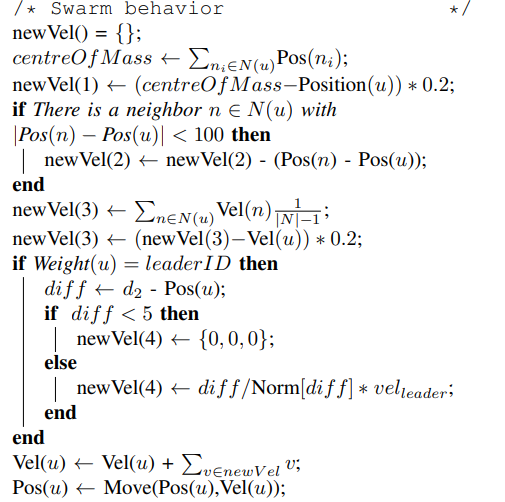

Consider the hexagonal topology from before and continue the test to find the most optimal path at every sample of optimization measurement.

In [68]:
## Initializing the Network ##

edges = [(1,2),(1,3),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5),(4,6),(5,6)]
weights = [5,8,2,7,4,3,1,1,2,10] ## Initial set of weights(arbitrary)

nodes = 6
## Set the source and destination nodes ##
source = 1
destination = 6

In [69]:
def calculate_distance(pos1, pos2):
    
    distance = sum(((np.array(pos2) - np.array(pos1)))**2)
    return distance


def calculate_costs(positions):
    ## Assign weights based on cartesian distances
    new_weights = []
    i=0
    for i in range(len(edges)):
        node1 = edges[i][0] - 1
        node2 = edges[i][1] - 1
        
        new_weights += [calculate_distance(positions[node1-1], positions[node2-1])]
            
    
    return new_weights

def CentreOfMass(positions):
    com = np.array([0,0,0])
    for i in range(len(positions)):
        com = com + np.array(list(positions[i]))
        
    return com

def update_positions(positions, velocity, ts):
    positions = np.array(positions) + velocity*ts
    return positions

def sample(positions, velocity, ts): ## This function runs after a set amount of time(sampling time)
    
    new_vel = [] ##Contains the velocities of each node
    com = CentreOfMass(positions) ## Assume all nodes are nearest neighbours, so one COM for the entire swarm
    for i in range(nodes):
        new_vel = new_vel + [(abs(com-np.array(positions[i]))*0.2)]  ## newVel(1) in algorithm
        
    # new_vel = np.array(new_vel) ## newVel(1)
    
    for i in range(nodes):
        j = i+1
        while j<nodes:
            dist = np.array(calculate_distance(positions[i], positions[j]))
            if dist<100:
                new_vel[i] = new_vel[i] - (np.array(positions[j])-np.array(positions[i])) ## newVel(2)
            j+=1
            
    ## Since we have considered each node to have the same number of nearest neighbors that is all the nodes
    N = nodes-1 ## Each node has nodes-1 nearest neigbors
    
    new_vel3 = np.array(new_vel)*N/(N-1)
    new_vel3 = np.array((new_vel3 - velocity))*0.2
    new_vel += new_vel3
    del(new_vel3)
    
    ## If we consider the model to have a leader in the network ##
    leader = destination ## We want the destination node to determine how the network evolves with time
    
    for i in range(nodes):
        if i == leader:
            continue    
        else:
            dist = calculate_distance(positions[i], positions[leader-1])
            if dist >= 5: ## We essentially want the distances between the nodes and the leader to be less than 5
                new_vel[i] += velocity[leader-1]
                
    velocity = np.array(velocity) + new_vel            
    
    positions = update_positions(positions, velocity, ts)
    
    weights = calculate_costs(positions)
    
    optimal_path_cost = Static_Model(edges, weights, nodes, source, destination)
    
    G = nx.DiGraph()
    
    for i in range(len(edges)):
        G.add_edge(edges[i][0],edges[i][1],weight=weights[i])
    
    actual_cost_opt = nx.dijkstra_path_length(G, source=source, target=destination)
    
    #print(optimal_path_cost)
    #print(actual_cost_opt)
    
    return optimal_path_cost/actual_cost_opt

In [71]:
import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

positions = [(0,0,0), (1,1,1), (1,1,-1), (2,2,0), (2,2,2), (5,0,0)] #Example of initial positions
velocity = [(1,2,3),(2,-7,8),(6, -4, 0),(-8, 6, 8), (2,2,2), (5,0,0)] # Example of initial velocities

def run(ts):
    approx_ratio = []
    while ts<=60:
        approx_ratio.append(sample(positions, velocity, ts))
        ts+=1

    print(approx_ratio)
    
run(ts=1)

[1.2122939774023012, 1.0571864277544794, 1.4617815090755493, 1.123560360680693, 1.138002994147802, 1.1124496350215767, 1.1550062125693876, 1.1604299182646551, 1.5725091786895251, 1.9123992721601248, 1.7847331153253394, 1.4475812874201037, 1.0, 1.9258999928272842, 1.0, 1.0, 1.9319046697975053, 0.0, 0.0, 1.5868150819158109, 1.5873784680345344, 1.0, 1.5190904046332834, 1.7873981949161786, 1.4546488445941885, 1.1874684623748872, 2.2748588565271586, 1.5902021030841218, 1.18874195752886, 1.5907681680693129, 1.1894551902391532, 1.1022043812294111, 1.9456002226300775, 1.522019527146693, 1.1906389689736712, 1.7881201709206653, 1.9471830370971903, 1.1913643932659408, 1.5926000324618421, 1.5927528970288798, 1.7882942064660818, 1.192171434665001, 0.0, 0.0, 1.101474111048936, 1.9497421039321132, 1.523719588543839, 1.5238123468709865, 1.9503870389147309, 1.457931958623936, 1.1935268128880268, 1.0, 1.7885761671847333, 1.0, 1.1011453010024865, 1.7886275399350005, 1.1010932716148674, 0.0, 1.19438600555

In [ ]:

plt.pyplot.plot()

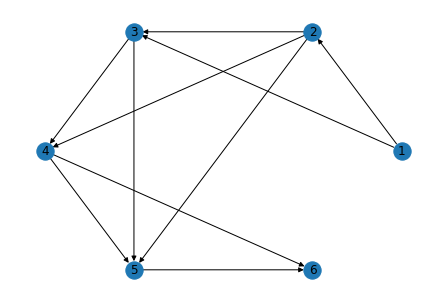

In [61]:
import networkx as nx
edges = [(1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6)]
G = nx.DiGraph()
G.add_nodes_from([1,2,3,4,5,6])
pos = nx.circular_layout(G)

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])
    
nx.draw(G, pos, with_labels=True)